<a href="https://colab.research.google.com/github/danielfoliveira4040/neural-network-stock-price/blob/main/Stock_Market_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PREVISÃO DO MERCADO DE AÇÕES COM BASE EM REDES NEURAIS RECORRENTES**

In [26]:
!pip3 install numpy
!pip3 install pandas
!pip3 install matplotlib
!pip3 install tensorflow
!pip3 install scikit-learn
!pip3 install keras
!pip3 install seaborn

# Introdução

O trabalho final desenvolvido para a Pós-Graduação do Curso de Especialização da PucMinas neste notebook explora um algoritmo de Aprendizado de Máquina denominado Rede Neural Recorrente (RNN), uma técnica de Deep Learning comumente usada para reconhecimento de padrão de dados contínuos. A Rede Neural Recorrente leva em consideração como os dados mudam ao longo do tempo e normalmente é usada para dados de série temporal (preços de ações, leituras de sensores, etc.)

Será feita uma tentativa de previsão do preço das ações da Cia. Berkshire Hathaway utilizando seu histórico de preço desde o IPO na Nasdaq, uma das maiores bolsas de valores dos Estados Unidos.

Link para o vídeo do Youtube: 


# Objetivo

Foram utilizados dados do próprio mercado para realização do treino e das previsões. Os dados foram retirados especificamente da API do [Yahoo! Finance](https://finance.yahoo.com/quote/BRK-A/history). Os dados demandaram um certo nível de tratamento. Com algumas modificações via Excel já foi possível utilizá-los para o trabalho.

As informações que compoem o dataset são:


1.   Date: data do registro do pregão
2.   Open: preço de abertura da ação
3.   High: máxima de preço atingido no pregão
4.   Low: mínima de preço atingido no pregão
5.   Close: preço de fechamento do pregão
6.   Volume: volume de negociação

# Metodologia

![](https://iamtrask.github.io/img/backprop_through_time.gif)

Uma rede neural recorrente (RNN) é uma classe de redes neurais artificiais onde as conexões entre os nós formam um grafo digirido ao longo de uma série temporal. Isso permite que ele exiba um comportamento dinâmico temporal.

Como as redes neurais de feedforward e convolucionais (CNNs), as redes neurais recorrentes utilizam dados de treinamento para aprender. O RNN se distingue por sua “memória”, pois recebe informações de entradas anteriores para influenciar a entrada e a saída atuais. Enquanto as redes neurais de deep learning tradicionais presumem que as entradas e saídas são independentes umas das outras, a saída das redes neurais recorrentes depende dos elementos anteriores dentro da sequência (vide figura acima).

# O problema (RNN Gradiente)

O gradiente é usado para atualizar os pesos em um RNN, olhando para trás um certo número de etapas definidas pelo usuário. Quanto mais baixo o gradiente, mais difícil é atualizar os pesos (gradiente de dissipação) dos nós mais para trás no tempo. Especialmente porque as camadas anteriores são usadas como entradas para as camadas futuras. Isso significa que os neurônios antigos estão treinando muito mais devagar do que os neurônios atuais. É como um efeito dominó.

# Solução (LSTM)

A solução escolhida aqui foi o LSTM. O Long short-term memory (LSTM) é uma arquitetura de rede neural recorrente artificial (RNN) usada no campo do deep learning. Ao contrário das redes neurais feedforward padrão, o LSTM tem conexões de feedback. Ele pode processar não apenas pontos de dados únicos (como imagens), mas também sequências inteiras de dados (como fala ou vídeo). Por exemplo, o LSTM é aplicável a tarefas como reconhecimento de manuscrito, reconhecimento de voz e previsão para preço de ações, que é o nosso caso de estudo.

![](https://www.researchgate.net/profile/Olivier-Risser-Maroix/publication/325929737/figure/fig1/AS:640313823617025@1529674120535/Cellule-de-type-LSTM.png)

Uma unidade LSTM comum é composta de uma célula, uma porta de entrada, uma porta de saída e uma porta de esquecimento. A célula lembra valores em intervalos de tempo arbitrários e as três portas regulam o fluxo de informações para dentro e para fora da célula.

**PRÉ-PROCESSAMENTO DOS DADOS**




In [4]:
#Bibliotecas básicas do python

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns



In [27]:
# Utilização do pandas para leitura dos dados do arquivo CSV
csv_treino = pd.read_csv('https://gist.githubusercontent.com/danielfoliveira4040/0967e21eae841c98e9dfe85fe87233c7/raw/36024ec5a54b939469044eccaa22f9dadd386579/train.csv')
set_treino = csv_treino.iloc[:, 1:2].values



**ANÁLISE EXPLORATÓRIA DOS DATASETS**

In [28]:
# Uso do sklearn para normalização das features do dataset 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
set_treino_normalizado = sc.fit_transform(set_treino)

x_treino = []
y_treino = []

#Salvamos em x_treino a entrada com os 60 dias anteriores a cada registro de preço e em  y_treino os dias posteriores
for i in range(60, len(csv_treino)-1):
    x_treino.append(set_treino_normalizado[i-60:i, 0])
    y_treino.append(set_treino_normalizado[i, 0])
x_treino, y_treino = np.array(x_treino), np.array(y_treino)

x_treino = np.reshape(x_treino, (x_treino.shape[0], x_treino.shape[1], 1))

csv_treino

,Date,Open,High,Low,Close,Volume
0,5/9/1996,22.200001,24.400000,22.200001,23.200001,4290000
1,5/10/1996,24.000000,24.200001,23.600000,24.000000,1060000
2,5/13/1996,24.000000,24.100000,23.299999,23.900000,700000
3,5/14/1996,24.000000,24.100000,23.100000,23.600000,310000
4,5/15/1996,23.600000,23.700001,23.000000,23.200001,545000
...,...,...,...,...,...,...
5695,12/24/2018,190.699997,191.639999,187.110001,187.759995,5020600
5696,12/26/2018,188.649994,197.929993,186.100006,197.570007,7158200
5697,12/27/2018,195.600006,200.119995,191.899994,200.119995,7386800
5698,12/28/2018,200.720001,204.740005,200.199997,202.080002,5420600


O dataset acima contém 6 colunas:

Date: Data da negociação

Open: Preço de abertura da ação no dia

High: Maior preço da ação no dia

Low: Menor preço da ação no dia

Close: Preço de fechamento da ação no dia

Volume: Volume total negociado no dia


In [20]:
#Descrição estatística do conjunto de dados da BRK-B
csv_treino.describe()

,Open,High,Low,Close,Volume
count,5700.000000,5700.000000,5700.000000,5700.000000,5.700000e+03
mean,81.721481,82.288404,81.070599,81.706326,2.227972e+06
std,47.215572,47.430871,46.917311,47.181404,4.961977e+06
min,20.100000,20.360001,19.799999,20.100000,1.000000e+04
25%,47.434999,47.959999,47.000000,47.419998,5.100000e+05
50%,66.170002,66.639999,65.645001,66.130001,1.170000e+06
75%,108.430002,109.227497,108.147503,108.674999,3.363525e+06
max,224.000000,224.070007,221.300003,223.759995,3.161342e+08


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribuição do Preço de Fechamento da Berkshire')

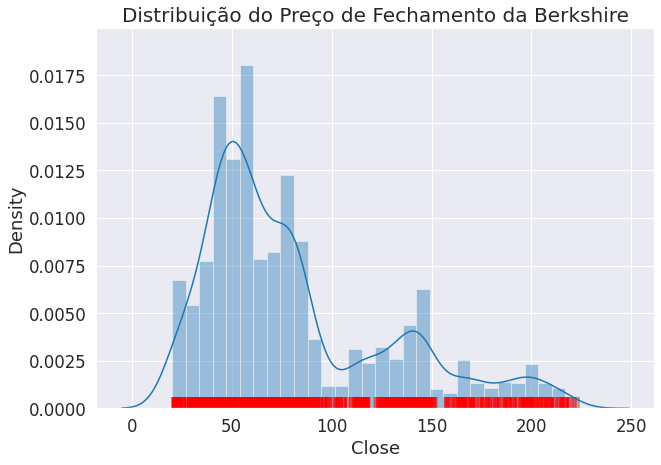

In [21]:
#Plotagem do histograma de distribuição da BRK-B com os preços de fechamento diários
plt.figure(figsize=(10, 7))
sns.set_context('notebook', font_scale=1.5, rc={'font.size':20, 'axes.titlesize':20, 'axes.labelsize':18})
sns.distplot(csv_treino['Close'], 
            kde=True,
            rug=True,
            rug_kws={"color": "r", "alpha": 0.3, "linewidth": 2, "height":0.03})
sns.set_style('darkgrid')
plt.title('Distribuição do Preço de Fechamento da Berkshire')

In [22]:
#Retorna a data com o maior volume de negociação de todo o conjunto de dados
max_volume = csv_treino['Volume'].argmax()
csv_treino.iloc[max_volume,:]


Date      2/12/2010
Open          77.15
High          77.86
Low           74.57
Close          76.9
Volume    316134200
Name: 3464, dtype: object

Text(0.5, 1.0, 'Variação de preço diário da BERKSHIRE HATHAWAY')

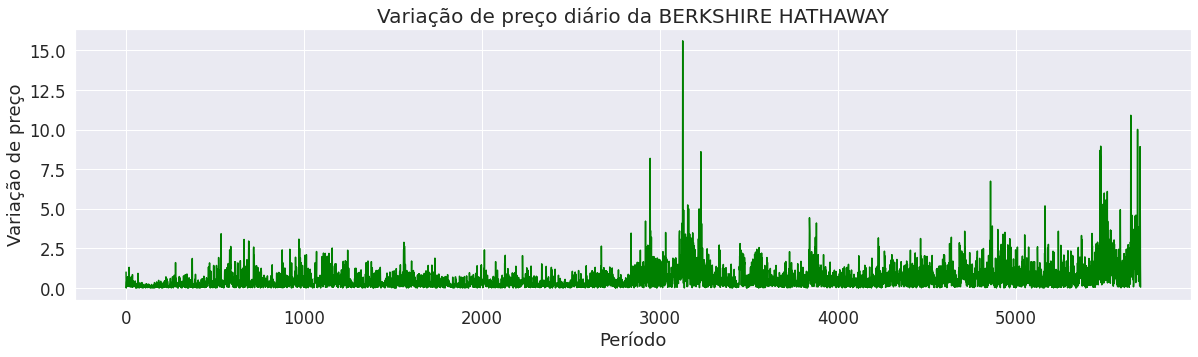

In [23]:
#Plotagem das variações de preços diárias (Valores absolutos)
variation_brk = abs(csv_treino['Close'] - csv_treino['Open'])
plt.figure(figsize=(20,5))
variation_brk.plot(label = 'Variação de preço', color = 'green')
plt.ylabel('Variação de preço')
plt.xlabel('Período')
plt.title('Variação de preço diário da BERKSHIRE HATHAWAY')

**1 - CONSTRUÇÃO DA RNN**

In [14]:
#Construção da RNN com o LSTM empilhado com regularização de dropout
#Dropout é realizado via keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

#Compilação do RNN
regressor = Sequential()
#Para maior dimensionalidade estabeleceu-se 50 células LSTM de memória
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (x_treino.shape[1], 1)))
regressor.add(Dropout(0.2))
#20% das células de memória são ignoradas para prevenir o overfitting a cada dropout.
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
#O algoritmo de Adam foi escolhido na compilação da RNN como otimizador
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(x_treino, y_treino, epochs = 100, batch_size = 32)


Epoch 1/100
177/177 [==============================] - 28s 120ms/step - loss: 0.0053
Epoch 2/100
177/177 [==============================] - 21s 119ms/step - loss: 0.0016
Epoch 3/100
177/177 [==============================] - 21s 119ms/step - loss: 0.0014
Epoch 4/100
177/177 [==============================] - 21s 120ms/step - loss: 0.0016
Epoch 5/100
177/177 [==============================] - 21s 119ms/step - loss: 0.0012
Epoch 6/100
177/177 [==============================] - 21s 120ms/step - loss: 0.0012
Epoch 7/100
177/177 [==============================] - 21s 120ms/step - loss: 0.0011
Epoch 8/100
177/177 [==============================] - 21s 120ms/step - loss: 0.0011
Epoch 9/100
177/177 [==============================] - 21s 120ms/step - loss: 9.3618e-04
Epoch 10/100
177/177 [==============================] - 21s 120ms/step - loss: 9.0786e-04
Epoch 11/100
177/177 [==============================] - 21s 119ms/step - loss: 8.9502e-04
Epoch 12/100
177/177 [=============================

2 - CONSTRUÇÃO DA RNN

In [24]:
#Construindo a Rede Neural Recorrente
#O preço verdadeiro do ano a ser calculado (2019) é carregado como o dataset de teste
csv_teste = pd.read_csv('https://gist.githubusercontent.com/danielfoliveira4040/7424ec86d261e7562c96f67e2aba5f96/raw/876d69dc0d07f6cc4acf6a23de168fd1098df1d7/test.csv')
preco_real_acao = csv_teste.iloc[:, 1:2].values

dataset_total = pd.concat((csv_treino['Open'], csv_teste['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(csv_teste) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
x_teste = []



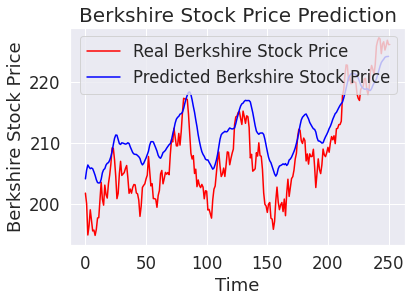

In [25]:
for i in range(60, 60+len(csv_teste)-1):
    x_teste.append(inputs[i-60:i, 0])

x_teste = np.array(x_teste)
x_teste = np.reshape(x_teste, (x_teste.shape[0], x_teste.shape[1], 1))
previsao_preco_acao = regressor.predict(x_teste)
previsao_preco_acao = sc.inverse_transform(previsao_preco_acao)


plt.plot(preco_real_acao, color = 'red', label = 'Real Berkshire Stock Price')
plt.plot(previsao_preco_acao, color = 'blue', label = 'Predicted Berkshire Stock Price')
plt.title('Berkshire Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Berkshire Stock Price')
plt.legend()
plt.show()


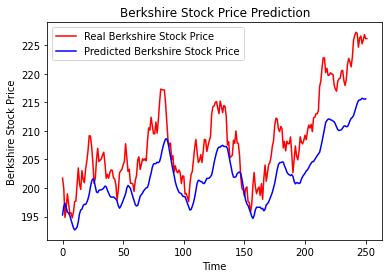

Os resultados acima foram atingidos a partir de um treinamento com os dados de 1996 a 2018 e um teste com o ano completo de 2019. 


Os resultados obtidos foram bastante atrativos.

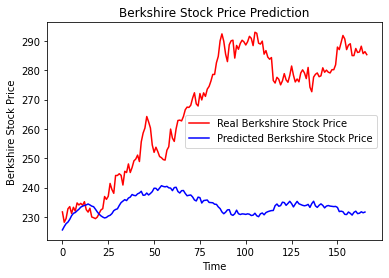

CURIOSIDADE: O treino de 1996 a 2020 com testes em 2021 não obteve resultados satisfatórios. Podemos atribuir a acurácia baixa ao evento de pandemia que estamos vivendo desde 2020 que afetou fortemente o mercado financeiro, criando tendências fora do padrão. Como os dados utilizados no dataset se resumem exclusivamente ao preço da ação, a rede neural não tem conhecimento desse fato relevante.

# Conclusão

O trabalho foi desenvolvido com sucesso, obtendo-se um resultado interessante para uma primeira tentativa de previsão. 

Levando em consideração o número baixo e de alta correlação entre features, sabe-se que existem muitas possibilidades de otimização que certamente tenderiam a melhorar a performance da rede, obtendo-se assim resultados mais satisfatórios. 

Outro caminho possível de melhoria poderia ser a análise de outras ações dos mesmos setores ou com outro tipo de correlação, a fim de refinar ainda mais o modelo.
